In [ ]:
pip install opendatasets

In [ ]:
pip install pandas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
# Data Preprocessing
import opendatasets as od
import pandas as pd

# importing data from Kaggle dataset
od.download("https://www.kaggle.com/datasets/vijayvvenkitesh/microsoft-stock-time-series-analysis")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: tasmiaaa
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/vijayvvenkitesh/microsoft-stock-time-series-analysis


100%|██████████| 26.7k/26.7k [00:00<00:00, 64.6MB/s]

In [ ]:
!ls microsoft-stock-time-series-analysis


In [ ]:
df = pd.read_csv('microsoft-stock-time-series-analysis/Microsoft_Stock.csv')
df.head()


,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438


In [ ]:
# Check info
df.info()

# Convert Date column
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Fill any missing values (forward-fill works best for time series)
df = df.fillna(method='ffill')

# Quick look
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1511 entries, 0 to 1510
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1511 non-null   object 
 1   Open    1511 non-null   float64
 2   High    1511 non-null   float64
 3   Low     1511 non-null   float64
 4   Close   1511 non-null   float64
 5   Volume  1511 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 71.0+ KB


/tmp/ipython-input-1118739656.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


,Date,Open,High,Low,Close,Volume
0,2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
1,2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2,2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
3,2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
4,2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438


In [ ]:
# Lag features (previous days' closing prices)
for lag in [1, 2, 3, 5]:
    df[f'Close_lag{lag}'] = df['Close'].shift(lag)

# Rolling averages and daily return
df['MA5'] = df['Close'].rolling(window=5).mean()
df['MA10'] = df['Close'].rolling(window=10).mean()
df['Return'] = df['Close'].pct_change()

# Drop NaN rows caused by shifting/rolling
df = df.dropna().reset_index(drop=True)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

features = ['Open', 'High', 'Low', 'Close', 'Volume',
            'Close_lag1', 'Close_lag2', 'Close_lag3', 'MA5', 'MA10', 'Return']

scaled = scaler.fit_transform(df[features])
df_scaled = pd.DataFrame(scaled, columns=features)

# Keep Date column for reference
df_scaled['Date'] = df['Date']


In [ ]:
# Rebuild the label correctly
df_scaled['Label'] = df_scaled['Close'].shift(-1)
df_scaled = df_scaled.dropna().reset_index(drop=True)


In [ ]:
df_scaled[['Date', 'Close', 'Label']].tail(10)


,Date,Close,Label
1491,2021-03-17 16:00:00,0.961128,0.930227
1492,2021-03-18 16:00:00,0.930227,0.928418
1493,2021-03-19 16:00:00,0.928418,0.955995
1494,2021-03-22 16:00:00,0.955995,0.963769
1495,2021-03-23 16:00:00,0.963769,0.953403
1496,2021-03-24 16:00:00,0.953403,0.938148
1497,2021-03-25 16:00:00,0.938148,0.958390
1498,2021-03-26 16:00:00,0.958390,0.952327
1499,2021-03-29 16:00:00,0.952327,0.935752
1500,2021-03-30 16:00:00,0.935752,0.954919


In [ ]:
n = len(df_scaled)
train_size = int(0.8 * n)
val_size   = int(0.1 * n)

train = df_scaled.iloc[:train_size]
val   = df_scaled.iloc[train_size:train_size + val_size]
test  = df_scaled.iloc[train_size + val_size:]

# Always reset indices
train = train.reset_index(drop=True)
val   = val.reset_index(drop=True)
test  = test.reset_index(drop=True)

X_train, y_train = train[features], train['Label']
X_val, y_val     = val[features], val['Label']
X_test, y_test   = test[features], test['Label']


In [ ]:
X_train.var()


,0
Open,0.025097
High,0.025441
Low,0.024993
Close,0.025082
Volume,0.009704
Close_lag1,0.024980
Close_lag2,0.024881
Close_lag3,0.024791
MA5,0.025371
MA10,0.025238


In [ ]:
X_train.describe().T[['min','max']]

,min,max
Open,0.000000,0.620637
High,0.000000,0.615148
Low,0.000000,0.618652
Close,0.000000,0.619157
Volume,0.000000,1.000000
Close_lag1,0.000000,0.614610
Close_lag2,0.000000,0.600479
Close_lag3,0.000000,0.600479
MA5,0.000000,0.605542
MA10,0.000000,0.597809


In [ ]:
print(y_train.min(), y_train.max())
y_train.describe()

0.0 0.6191570506551927


,Label
count,1200.000000
mean,0.213733
std,0.158690
min,0.000000
25%,0.073061
50%,0.163236
75%,0.328550
max,0.619157


In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Predictions range:", y_pred_rf.min(), "→", y_pred_rf.max())
print("Labels range:", y_test.min(), "→", y_test.max())


Predictions range: 0.6154251906903948 → 0.616464795619008
Labels range: 0.7819284177586544 → 1.0


In [ ]:
print("Predictions range:", y_pred_rf.min(), "→", y_pred_rf.max())
print("Labels range:", y_test.min(), "→", y_test.max())


Predictions range: 0.6154251906903948 → 0.616464795619008
Labels range: 0.7819284177586544 → 1.0


In [ ]:
print("Scaled Close range:", df_scaled['Close'].min(), "→", df_scaled['Close'].max())
print("Scaled Label range:", df_scaled['Label'].min(), "→", df_scaled['Label'].max())


Scaled Close range: 0.0 → 1.0
Scaled Label range: 0.0 → 1.0


Prediction range: 0.6154251906903948 → 0.616464795619008
Label range: 0.7819284177586544 → 1.0
RMSE: 0.2746,  MAE: 0.2684


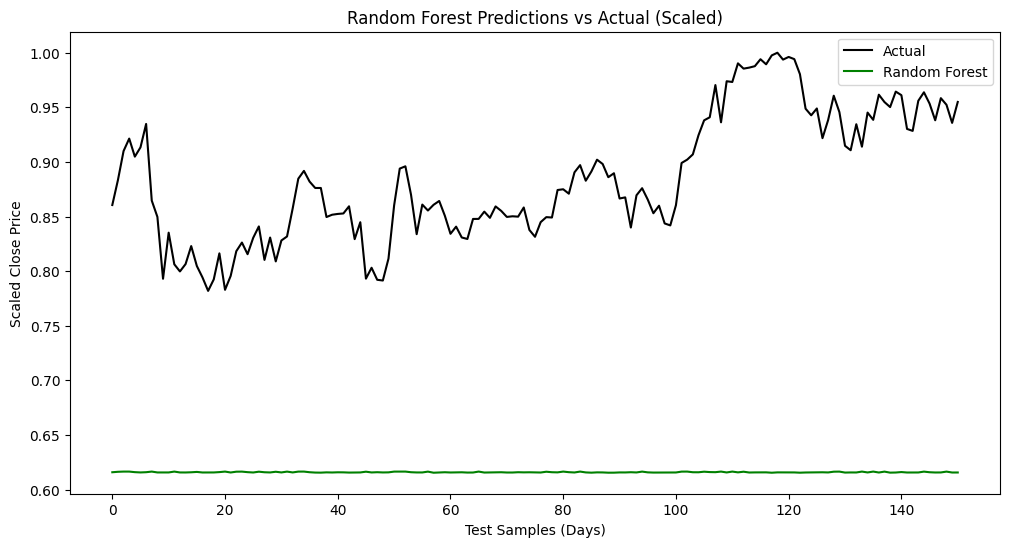

In [ ]:
num_cols = ['Open','High','Low','Close','Volume',
             'Close_lag1','Close_lag2','Close_lag3','MA5','MA10','Return']

# ensure there are no missing rows from lagged features
df = df.dropna().reset_index(drop=True)

# scale both features and data together
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

scaled = scaler.fit_transform(df[num_cols])
df_scaled = pd.DataFrame(scaled, columns=num_cols)
df_scaled['Date'] = df['Date']

# shift label (next day close) and drop NaN
df_scaled['Label'] = df_scaled['Close'].shift(-1)
df_scaled = df_scaled.dropna().reset_index(drop=True)

# chronological split
n = len(df_scaled)
train_size = int(0.8 * n)
val_size   = int(0.1 * n)

train = df_scaled.iloc[:train_size].reset_index(drop=True)
val   = df_scaled.iloc[train_size:train_size + val_size].reset_index(drop=True)
test  = df_scaled.iloc[train_size + val_size:].reset_index(drop=True)

features = ['Open','High','Low','Close','Volume',
            'Close_lag1','Close_lag2','Close_lag3','MA5','MA10','Return']

X_train, y_train = train[features], train['Label']
X_val,   y_val   = val[features],   val['Label']
X_test,  y_test  = test[features],  test['Label']

# fit random forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

# confirm ranges overlap
print("Prediction range:", y_pred_rf.min(), "→", y_pred_rf.max())
print("Label range:", y_test.min(), "→", y_test.max())

# evaluate using mae and rmse
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae  = mean_absolute_error(y_test, y_pred_rf)
print(f"RMSE: {rmse:.4f},  MAE: {mae:.4f}")

# plotting
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(range(len(y_test)), y_test.values, label='Actual', color='black')
plt.plot(range(len(y_test)), y_pred_rf, label='Random Forest', color='green')
plt.title('Random Forest Predictions vs Actual (Scaled)')
plt.xlabel('Test Samples (Days)')
plt.ylabel('Scaled Close Price')
plt.legend()
plt.show()

In [ ]:
# using deeper trees
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


In [ ]:
X_train.var()

,0
Open,0.025097
High,0.025441
Low,0.024993
Close,0.025082
Volume,0.009704
Close_lag1,0.024980
Close_lag2,0.024881
Close_lag3,0.024791
MA5,0.025371
MA10,0.025238


In [ ]:
print(y_pred_rf[:10])


[0.61586212 0.61627577 0.6164648  0.6164648  0.61594876 0.61569137
 0.61589957 0.6164648  0.6156769  0.6156769 ]


In [ ]:
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f"Random Forest → RMSE: {rmse_rf:.4f}, MAE: {mae_rf:.4f}")


Random Forest → RMSE: 0.2746, MAE: 0.2684


In [ ]:
# baseline models
# Predict next day = today's close
y_pred_naive = X_test['Close'].values

rmse_naive = np.sqrt(mean_squared_error(y_test, y_pred_naive))
mae_naive  = mean_absolute_error(y_test, y_pred_naive)

print(f"Naïve Forecast → RMSE: {rmse_naive:.4f}, MAE: {mae_naive:.4f}")

Naïve Forecast → RMSE: 0.0191, MAE: 0.0146


In [ ]:
y_pred_ma = X_test[['Close_lag1','Close_lag2','Close_lag3','MA5']].mean(axis=1)

rmse_ma = np.sqrt(mean_squared_error(y_test, y_pred_ma))
mae_ma  = mean_absolute_error(y_test, y_pred_ma)

print(f"5-Day Moving Average → RMSE: {rmse_ma:.4f}, MAE: {mae_ma:.4f}")

5-Day Moving Average → RMSE: 0.0276, MAE: 0.0208


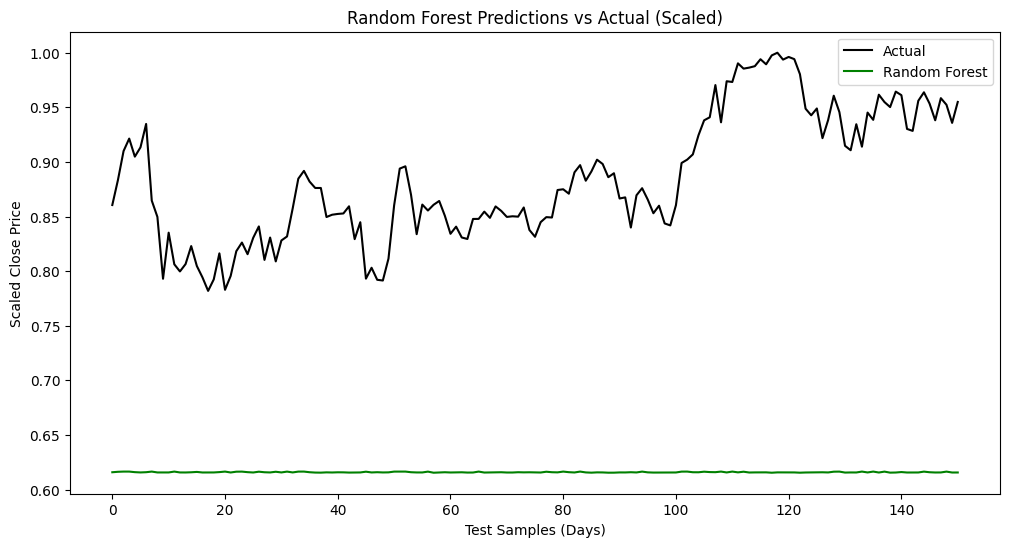

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(range(len(y_test)), y_test.values, label='Actual', color='black')
plt.plot(range(len(y_test)), y_pred_rf, label='Random Forest', color='green')
plt.title('Random Forest Predictions vs Actual (Scaled)')
plt.xlabel('Test Samples (Days)')
plt.ylabel('Scaled Close Price')
plt.legend()
plt.show()


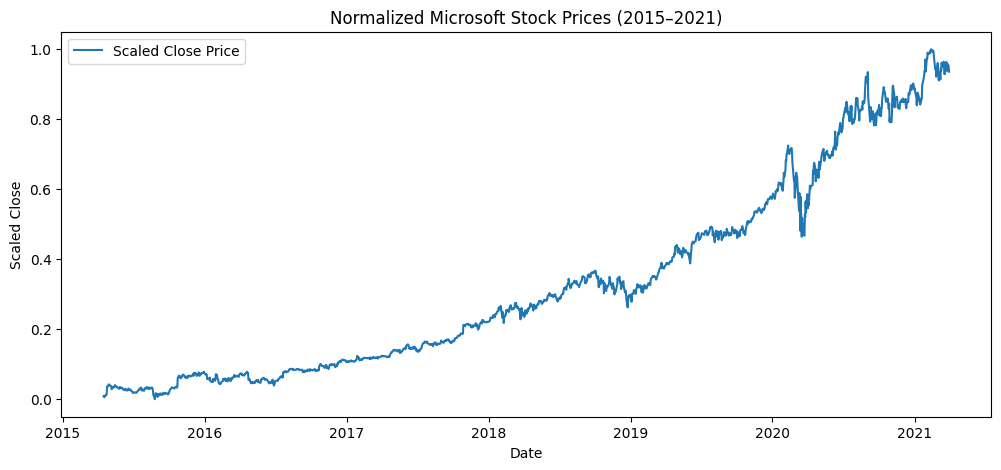

In [ ]:
# scaled close price
plt.figure(figsize=(12,5))
plt.plot(df_scaled['Date'], df_scaled['Close'], label='Scaled Close Price')
plt.title('Normalized Microsoft Stock Prices (2015–2021)')
plt.xlabel('Date')
plt.ylabel('Scaled Close')
plt.legend()
plt.show()


In [ ]:
#
rf = RandomForestRegressor(
    n_estimators=200,      # number of trees
    max_depth=None,        # let trees grow fully until each leaf contains only one target value
    random_state=42,
    n_jobs=-1              # use all CPU cores
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf  = mean_absolute_error(y_test, y_pred_rf)

print(f"Random Forest → RMSE: {rmse_rf:.4f}, MAE: {mae_rf:.4f}")


Random Forest → RMSE: 0.2744, MAE: 0.2682


In [ ]:
results = pd.DataFrame({
    'Model': ['Naïve Forecast', '5-Day MA', 'Random Forest'],
    'RMSE':  [rmse_naive, rmse_ma, rmse_rf],
    'MAE':   [mae_naive, mae_ma, mae_rf]
})
results

,Model,RMSE,MAE
0,Naïve Forecast,0.019120,0.014607
1,5-Day MA,0.027580,0.020762
2,Random Forest,0.274401,0.268205


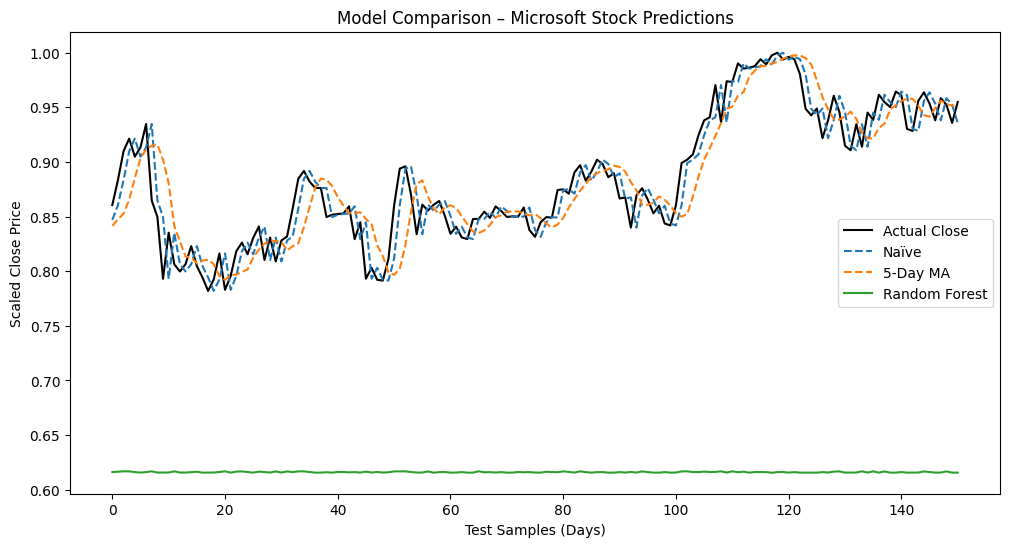

In [ ]:
plt.figure(figsize=(12,6))
x = range(len(y_test))  # consistent x for all predictions

plt.plot(x, y_test.values, label='Actual Close', color='black')
plt.plot(x, y_pred_naive, label='Naïve', linestyle='--')
plt.plot(x, y_pred_ma, label='5-Day MA', linestyle='--')
plt.plot(x, y_pred_rf, label='Random Forest', linestyle='-')

plt.title('Model Comparison – Microsoft Stock Predictions')
plt.xlabel('Test Samples (Days)')
plt.ylabel('Scaled Close Price')
plt.legend()
plt.show()


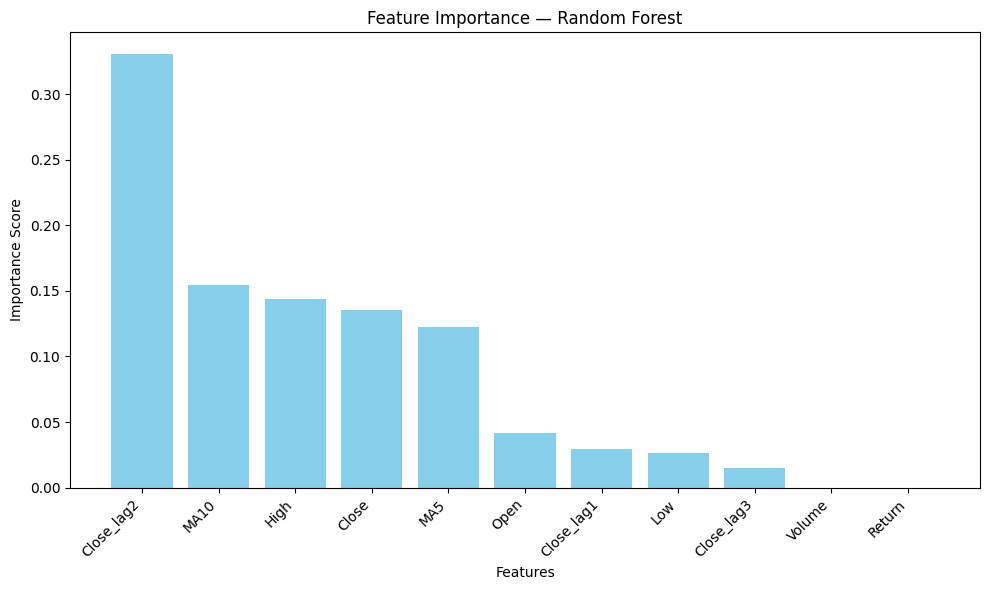

In [ ]:
# Feature selection
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]  # sort descending

plt.figure(figsize=(10,6))
plt.title("Feature Importance — Random Forest")
plt.bar(range(len(importances)), importances[indices], color='skyblue')
plt.xticks(range(len(importances)), np.array(X_train.columns)[indices], rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV
# grid search hyperparameter tuning using cross validation
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)

#grid search
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [ ]:
print("Best parameters:", grid_search.best_params_)
print("Best RMSE (cross-val):", -grid_search.best_score_)

Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best RMSE (cross-val): 0.07777678760134737


In [ ]:
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

y_pred_best = best_rf.predict(X_test)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
mae_best  = mean_absolute_error(y_test, y_pred_best)

print(f"Tuned Random Forest → RMSE: {rmse_best:.4f}, MAE: {mae_best:.4f}")


Tuned Random Forest → RMSE: 0.2745, MAE: 0.2683


In [ ]:
results = pd.DataFrame({
    'Model': ['Naïve', '5-Day MA', 'Random Forest (Default)', 'Random Forest (Tuned)'],
    'RMSE': [rmse_naive, rmse_ma, rmse_rf, rmse_best],
    'MAE': [mae_naive, mae_ma, mae_rf, mae_best]
})
results


,Model,RMSE,MAE
0,Naïve,0.019120,0.014607
1,5-Day MA,0.027580,0.020762
2,Random Forest (Default),0.274555,0.268360
3,Random Forest (Tuned),0.274530,0.268334


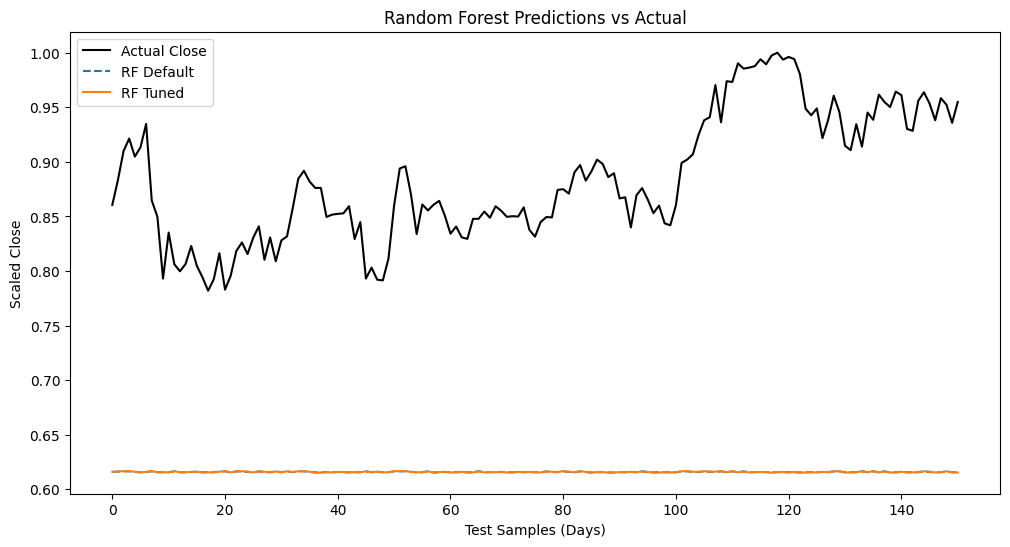

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Actual Close', color='black')
plt.plot(y_pred_rf, label='RF Default', linestyle='--')
plt.plot(y_pred_best, label='RF Tuned', linestyle='-')
plt.title('Random Forest Predictions vs Actual')
plt.xlabel('Test Samples (Days)')
plt.ylabel('Scaled Close')
plt.legend()
plt.show()


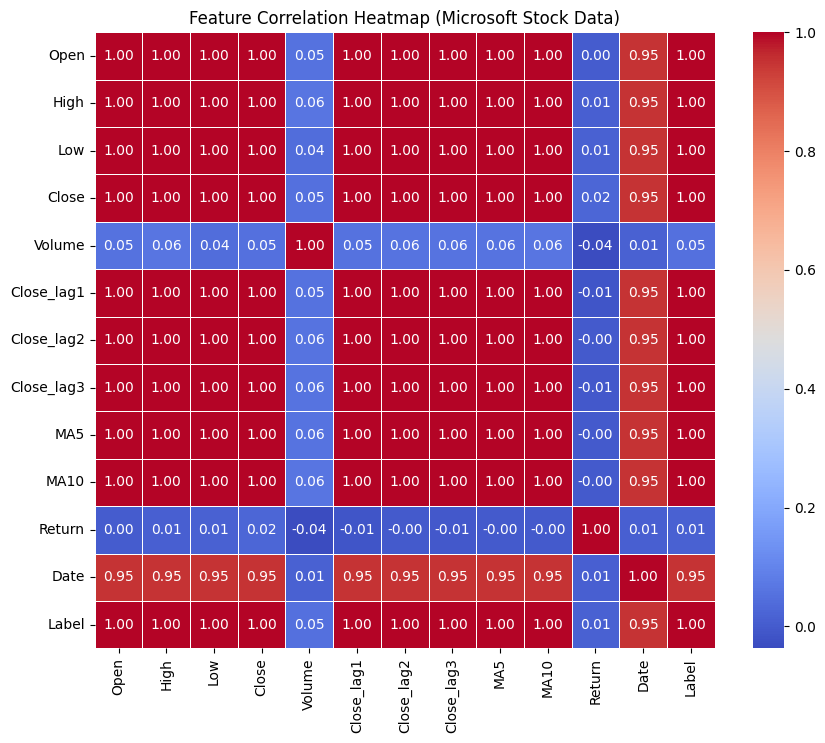

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# correlation matrix
corr = df_scaled.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap (Microsoft Stock Data)")
plt.show()


## Model Comparison using SVR & LSTM

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

📊 Model Performance (USD)
Naïve           RMSE:    5.174 | MAE:    3.889
5-Day MA        RMSE:    5.392 | MAE:    4.083
SVR (RBF)       RMSE:  126.854 | MAE:  126.200
LSTM            RMSE:    6.407 | MAE:    4.913


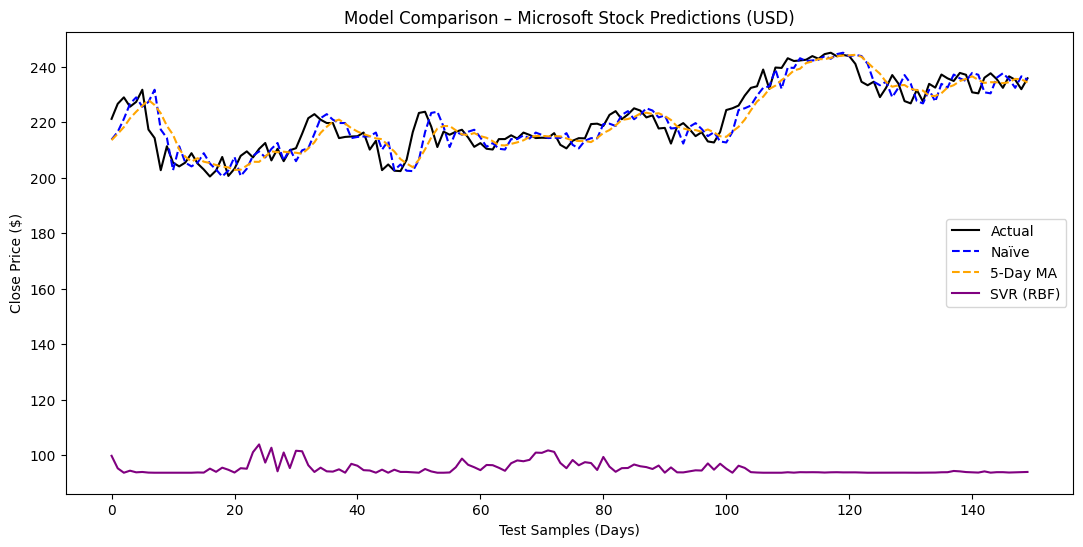

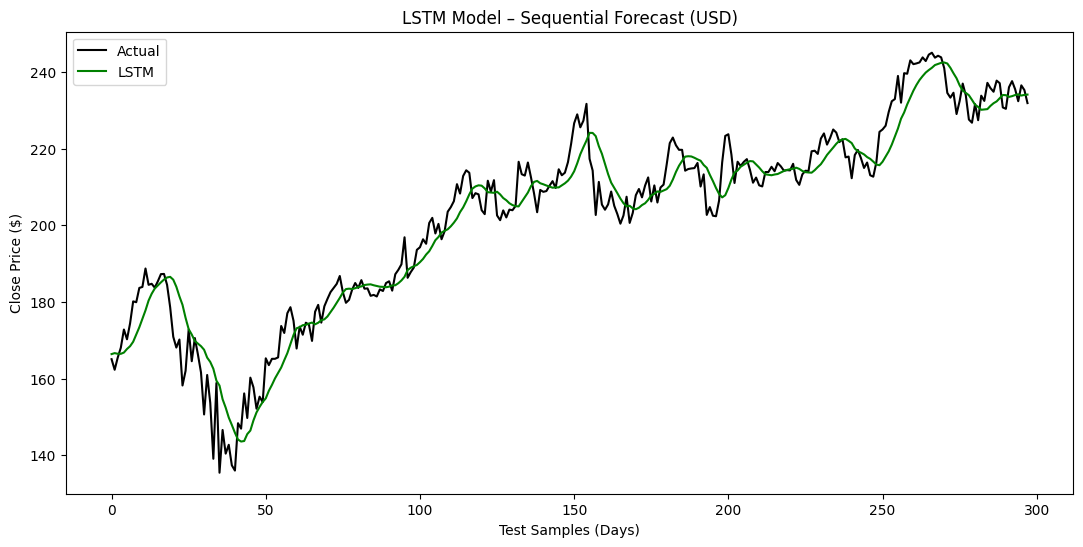

In [ ]:
# Load Data
df = pd.read_csv('/content/microsoft-stock-time-series-analysis/Microsoft_Stock.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

#Fe ature Engineering
for lag in [1,2,3,5,10]:
    df[f'Close_lag{lag}'] = df['Close'].shift(lag)
df['MA5'] = df['Close'].rolling(5).mean()
df['MA10'] = df['Close'].rolling(10).mean()
df['Volatility'] = df['High'] - df['Low']
df['Return'] = df['Close'].pct_change()
df['Diff'] = df['Close'] - df['Close'].shift(1)
df['MA_diff'] = df['MA5'] - df['MA10']
df = df.dropna().reset_index(drop=True)

# Target (next day's Close)
df['Label'] = df['Close'].shift(-1)
df = df.dropna().reset_index(drop=True)

# Chronological Split
n = len(df)
train_size = int(0.8 * n)
val_size   = int(0.1 * n)

train = df.iloc[:train_size]
val   = df.iloc[train_size:train_size + val_size]
test  = df.iloc[train_size + val_size:]

features = ['Open','High','Low','Close','Volume',
            'Close_lag1','Close_lag2','Close_lag3','Close_lag5','Close_lag10',
            'MA5','MA10','Volatility','Return','Diff','MA_diff']

X_train, y_train = train[features], train['Label']
X_test,  y_test  = test[features],  test['Label']

# Baseline Models
y_pred_naive = test['Close_lag1'].values
y_pred_ma5   = test['MA5'].values


# SVR (RBF Kernel)
svr = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1))
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)

# LSTM Model
# Scale Close only for sequential model
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(df[['Close']])

# Build sequences
def create_sequences(data, seq_len=10):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

SEQ_LEN = 10
X_seq, y_seq = create_sequences(scaled_close, SEQ_LEN)

split = int(0.8 * len(X_seq))
X_train_seq, X_test_seq = X_seq[:split], X_seq[split:]
y_train_seq, y_test_seq = y_seq[:split], y_seq[split:]

model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(SEQ_LEN, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=16, validation_split=0.1, verbose=0)

y_pred_seq = model.predict(X_test_seq)
y_pred_lstm = scaler.inverse_transform(y_pred_seq)
y_test_lstm = scaler.inverse_transform(y_test_seq)

# Evaluation
def evaluate(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    print(f"{name:<15} RMSE: {rmse:8.3f} | MAE: {mae:8.3f}")
    return rmse, mae

print("\n📊 Model Performance (USD)")
evaluate("Naïve", y_test, y_pred_naive)
evaluate("5-Day MA", y_test, y_pred_ma5)
evaluate("SVR (RBF)", y_test, y_pred_svr)
evaluate("LSTM", y_test_lstm, y_pred_lstm)


# Visualization
plt.figure(figsize=(13,6))
plt.plot(y_test.values, label='Actual', color='black')
plt.plot(y_pred_naive, label='Naïve', linestyle='--', color='blue')
plt.plot(y_pred_ma5, label='5-Day MA', linestyle='--', color='orange')
plt.plot(y_pred_svr, label='SVR (RBF)', linestyle='-', color='purple')
plt.title('Model Comparison – Microsoft Stock Predictions (USD)')
plt.xlabel('Test Samples (Days)')
plt.ylabel('Close Price ($)')
plt.legend()
plt.show()

# Plot LSTM separately (different test size)
plt.figure(figsize=(13,6))
plt.plot(y_test_lstm, label='Actual', color='black')
plt.plot(y_pred_lstm, label='LSTM', color='green')
plt.title('LSTM Model – Sequential Forecast (USD)')
plt.xlabel('Test Samples (Days)')
plt.ylabel('Close Price ($)')
plt.legend()
plt.show()
